# Initialize Packages and Define Constants

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.integrate
import scipy.optimize
import scipy.signal

In [3]:
kB = 8.617e-5
muB = 5.788e-5
e = 1.602e-19
me = 9.109e-31
mu0 = 4*np.pi*1e-7
h = 4.135e-15
hb = 6.582e-16
eps0 = 8.854e-12
NA = 6.022e23

In [4]:
z = 2 # ion valence
T = 300 # ambient temperature

# 2D Electric Field Distribution from Interdigitated Electrode Geometry

### Calculate electric field and Potential

In [4]:
# Grid of x, y points
x_range = 20e-6
y_range = 10e-6 # 10 um (order of magnitude fluid thickness under coverslip)
t_range = 100e-6
nx, ny, nt = 200,200,200
t = np.linspace(0,t_range, nt)
dt = t[1]-t[0]
x = np.linspace(-x_range/2, x_range/2, nx)
dx = x[1]-x[0]
y = np.linspace(0, y_range, ny)
dy = y[1]-y[0]
X, Y = np.meshgrid(x, y)

V0 = 10

def E(q, r0, x, y):
    """Return the electric field vector E=(Ex,Ey) due to charge q at r0."""
    den = ((x-r0[0])**2 + (y-r0[1])**2)**1.5
    return ((q/(4*np.pi*eps0))*(x-r0[0])/den)*(den>(dx**2+dy**2)**1.5), ((q/(4*np.pi*eps0))*(y-r0[1])/den)*(den>(dx**2+dy**2)**1.5)

def V(q, r0, x, y):
    """Return the electric field vector E=(Ex,Ey) due to charge q at r0."""
    den = np.sqrt((x-r0[0])**2 + (y-r0[1])**2)
    return ((q/(4*np.pi*eps0))/den)*(den>np.sqrt(dx**2+dy**2))+(q/np.abs(q))*(V0/(nq/2))*(den<=np.sqrt(dx**2+dy**2))

nq, d, l = 100, 10e-6, 1e-6
dQ = ((np.pi*eps0*V0)/1.25)*(l/nq)
charges = []
for i in range(nq):
    charges.append((-dQ, (i/(nq-l/2)*l-l/2-d/2, 0)))
    charges.append((dQ, (i/(nq-l/2)*l-l/2+d/2, 0)))

# Electric field vector, E=(Ex, Ey), as separate components
Ex, Ey, Vxy = np.zeros((ny, nx)), np.zeros((ny, nx)), np.zeros((ny, nx))
for charge in charges:
    ex, ey = E(*charge, x=X, y=Y)
    vxy = V(*charge, x=X, y=Y)
    Ex += ex
    Ey += ey
    Vxy += vxy

### Plot electric field (magnitude and direction)

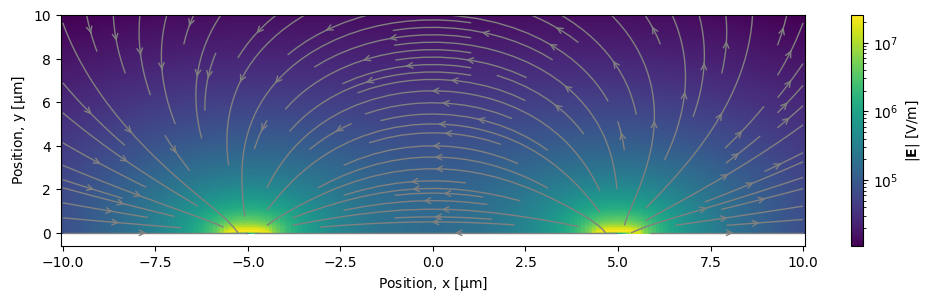

In [5]:
fig = plt.figure(figsize = (12,3))
ax = fig.add_subplot()

plt.pcolor(X*1e6,Y*1e6,np.sqrt(Ex**2 + Ey**2),norm=mpl.colors.LogNorm())
plt.colorbar(label='$|{\\bf E}|~\\mathrm{[V/m]}$')
plt.streamplot(x*1e6, y*1e6, Ex, Ey, color='gray', linewidth=1, density=1, arrowstyle='->')
plt.xlabel('Position, x $\\mathrm{[\\mu m]}$')
plt.ylabel('Position, y $\\mathrm{[\\mu m]}$');

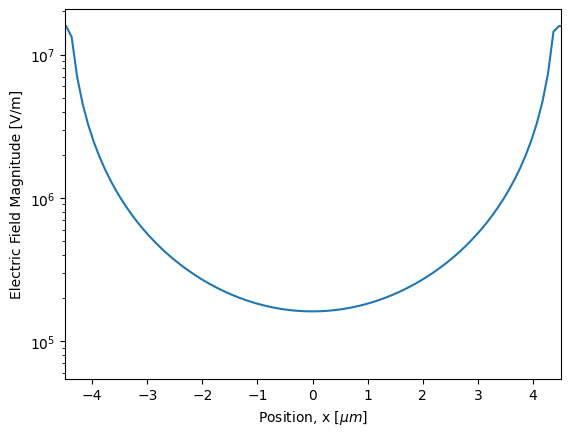

In [6]:
plt.semilogy(x*1e6,np.sqrt(Ex**2 + Ey**2)[0,:])
plt.xlabel('Position, x $[\\mu m]$')
plt.ylabel('Electric Field Magnitude [V/m]')
plt.xlim([-4.5,4.5]);

### Plot electric potential

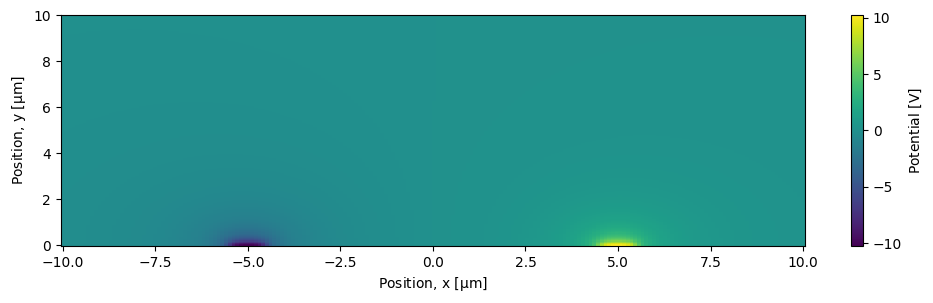

In [7]:
fig = plt.figure(figsize = (12,3))
ax = fig.add_subplot()

plt.pcolor(X*1e6,Y*1e6,Vxy)
plt.colorbar(label='Potential $\\mathrm{[V]}$')
# plt.clim([-1,1])
plt.xlabel('Position, x $\\mathrm{[\\mu m]}$')
plt.ylabel('Position, y $\\mathrm{[\\mu m]}$');

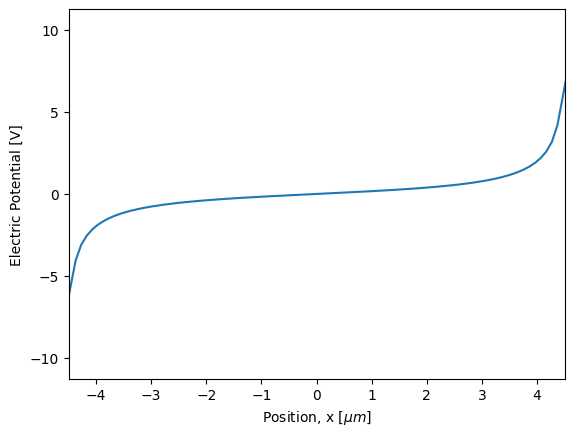

In [8]:
plt.plot(x*1e6,Vxy[0,:])
plt.xlabel('Position, x $[\\mu m]$')
plt.ylabel('Electric Potential [V]')
plt.xlim([-4.5,4.5]);

### Active-Area E-Field Nonuniformity vs Height
$\delta E(x,y) = |E(x,y)-E(x,0)|/E(x,0)$

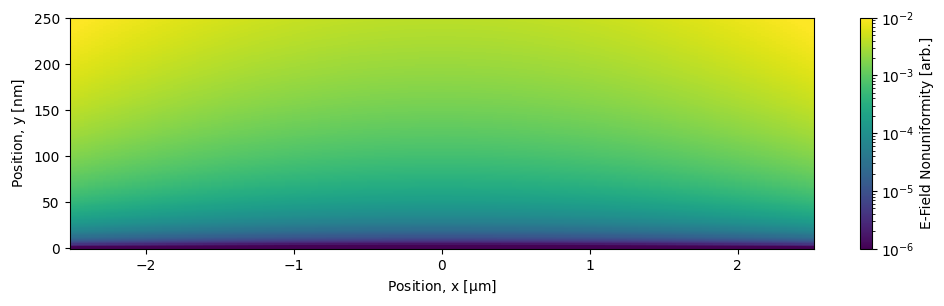

In [9]:
# Grid of x, y points
x_range_NU = 5e-6
y_range_NU = 250e-9 # 10 um (order of magnitude fluid thickness under coverslip)
x_NU = np.linspace(-x_range_NU/2, x_range_NU/2, nx)
dx_NU = x_NU[1]-x_NU[0]
y_NU = np.linspace(0, y_range_NU, ny)
dy_NU = y_NU[1]-y_NU[0]
X_NU, Y_NU = np.meshgrid(x_NU, y_NU)

# Electric field vector, E=(Ex, Ey), as separate components
Ex_NU, Ey_NU = np.zeros((ny, nx)), np.zeros((ny, nx))
for charge in charges:
    ex, ey = E(*charge, x=X_NU, y=Y_NU)
    Ex_NU += ex
    Ey_NU += ey

fig = plt.figure(figsize = (12,3))
ax = fig.add_subplot()

plt.pcolor(X_NU*1e6,Y_NU*1e9,np.abs(np.sqrt(Ex_NU**2 + Ey_NU**2)-np.sqrt(Ex_NU**2)[0,:])/np.sqrt(Ex_NU**2)[0,:]+1e-10,norm=mpl.colors.LogNorm())
plt.colorbar(label='E-Field Nonuniformity [arb.]')
plt.clim([1e-6,1e-2])
plt.xlabel('Position, x $\\mathrm{[\\mu m]}$')
plt.ylabel('Position, y $\\mathrm{[nm]}$');

# Debye-Huckel Model (Steady-State Ionic Shielding)

### Steady-state solute distribution

In [10]:
def dRho_DH(z,phi):
    return np.exp(-(z*phi)/(kB*T))

### Plot relative ionic concentration distribution for 1:1 (z = $\pm$ 2) solvent
$[c_{2+}(x,y)-c_{2-}(x,y)]/c_{i}(x,y)$

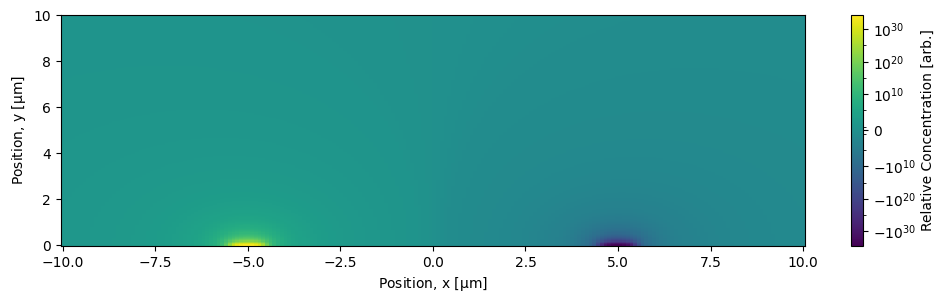

In [11]:
fig = plt.figure(figsize = (12,3))
ax = fig.add_subplot()

plt.pcolor(X*1e6,Y*1e6,dRho_DH(2,Vxy/10)-dRho_DH(-2,Vxy/10),norm = mpl.colors.SymLogNorm(1))
cbar = plt.colorbar(label='Relative Concentration [arb.]')
cbar.set_ticks([-1e30,-1e20,-1e10,0,1e10,1e20,1e30])
plt.xlabel('Position, x $\\mathrm{[\\mu m]}$')
plt.ylabel('Position, y $\\mathrm{[\\mu m]}$');

### 1D model (Guoy-Chapman)

In [12]:
x_test = np.linspace(-5e-6,5e-6,10001)
C0 = 1e-6 # initial solute concentration [mol/L]
kappa = (3.29e7*C0**(1/2))/1e-2 # inverse debye length for dilute aqueous solutions at STP [m^-1]

def V_GC(x,V,T,K): 
    return 4*kB*T*np.arctanh(np.tanh(V/(4*kB*T))*np.exp(-x*K))

def Ex_GC(x,V):
    return -np.gradient(V,x)

### Steady-state shielded electric potential and field vs electrode potential for $c_{i} = 1~\mathrm{[\mu M]}$ 

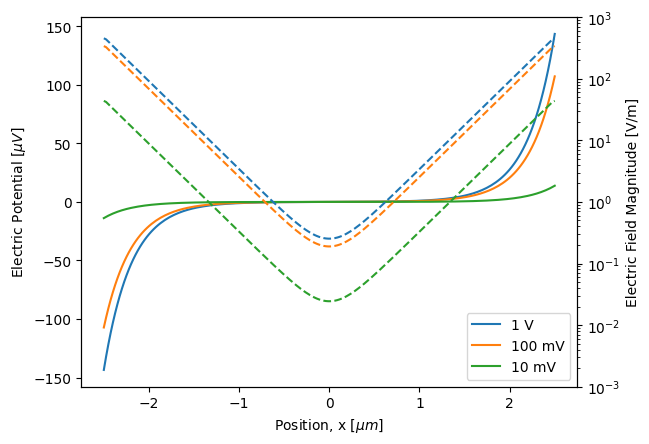

In [13]:
plt.plot(x_NU*1e6,(V_GC(4.5e-6-x_NU,1,300,kappa)-V_GC(x_NU+4.5e-6,1,300,kappa))*1e6,label='1 V')
plt.plot(x_NU*1e6,(V_GC(4.5e-6-x_NU,0.1,300,kappa)-V_GC(x_NU+4.5e-6,0.1,300,kappa))*1e6,label='100 mV')
plt.plot(x_NU*1e6,(V_GC(4.5e-6-x_NU,0.01,300,kappa)-V_GC(x_NU+4.5e-6,0.01,300,kappa))*1e6,label='10 mV')
plt.xlabel('Position, x $[\\mu m]$')
plt.ylabel('Electric Potential $[\\mu V]$')
plt.legend(loc = 'lower right')
plt.twinx()
plt.semilogy(x_NU*1e6,np.abs(Ex_GC(x_NU,V_GC(4.5e-6-x_NU,1,300,kappa)-V_GC(x_NU+4.5e-6,1,300,kappa))),'--')
plt.semilogy(x_NU*1e6,np.abs(Ex_GC(x_NU,V_GC(4.5e-6-x_NU,0.1,300,kappa)-V_GC(x_NU+4.5e-6,0.1,300,kappa))),'--')
plt.semilogy(x_NU*1e6,np.abs(Ex_GC(x_NU,V_GC(4.5e-6-x_NU,0.01,300,kappa)-V_GC(x_NU+4.5e-6,0.01,300,kappa))),'--')
plt.ylabel('Electric Field Magnitude [V/m]')
plt.ylim([1e-3,1e3]);

### Steady-state shielded electric potential and field vs $c_{i}$ for 1 V electrode potential

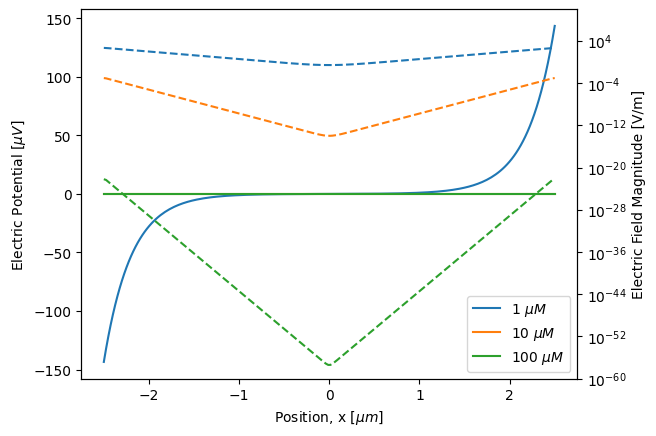

In [14]:
plt.plot(x_NU*1e6,(V_GC(4.5e-6-x_NU,1,300,(3.29e7*1e-6**(1/2))/1e-2)-V_GC(x_NU+4.5e-6,1,300,(3.29e7*1e-6**(1/2))/1e-2))*1e6,label='1 $\\mu M$')
plt.plot(x_NU*1e6,(V_GC(4.5e-6-x_NU,1,300,(3.29e7*1e-5**(1/2))/1e-2)-V_GC(x_NU+4.5e-6,0.1,300,(3.29e7*1e-5**(1/2))/1e-2))*1e6,label='10 $\\mu M$')
plt.plot(x_NU*1e6,(V_GC(4.5e-6-x_NU,1,300,(3.29e7*1e-4**(1/2))/1e-2)-V_GC(x_NU+4.5e-6,0.01,300,(3.29e7*1e-4**(1/2))/1e-2))*1e6,label='100 $\\mu M$')
plt.xlabel('Position, x $[\\mu m]$')
plt.ylabel('Electric Potential $[\\mu V]$')
plt.legend(loc = 'lower right')
plt.twinx()
plt.semilogy(x_NU*1e6,np.abs(Ex_GC(x_NU,V_GC(4.5e-6-x_NU,1,300,(3.29e7*1e-6**(1/2))/1e-2)-V_GC(x_NU+4.5e-6,1,300,(3.29e7*1e-6**(1/2))/1e-2))),'--')
plt.semilogy(x_NU*1e6,np.abs(Ex_GC(x_NU,V_GC(4.5e-6-x_NU,1,300,(3.29e7*1e-5**(1/2))/1e-2)-V_GC(x_NU+4.5e-6,1,300,(3.29e7*1e-5**(1/2))/1e-2))),'--')
plt.semilogy(x_NU*1e6,np.abs(Ex_GC(x_NU,V_GC(4.5e-6-x_NU,1,300,(3.29e7*1e-4**(1/2))/1e-2)-V_GC(x_NU+4.5e-6,1,300,(3.29e7*1e-4**(1/2))/1e-2))),'--')
plt.ylabel('Electric Field Magnitude [V/m]')
plt.ylim([1e-60,1e10]);

### Not looking good for a constant voltage...solute strongly shields electrodes at the steady state
### Maybe a pulsed/sinusoidal field is better? Determine the timescale of solute shielding

# Nernst-Planck Model (Charged Solution Diffusion in an Electric Field)
$\frac{\partial c}{\partial t}=\nabla \bullet D[\nabla c - \frac{ze}{k_{B}T}c\vec{E}]=D[\nabla^{2}c + \frac{ze}{k_{B}T}c\nabla^{2}V]$

### Approximate dynamics with in 1D with finite difference method
$c(x,t) \approx c(x,t-\Delta t) + D\Delta t[\frac{c(x+\Delta x,t-\Delta t)-2c(x,t-\Delta t)+c(x-\Delta x,t-\Delta t)}{\Delta x^{2}} + \frac{ze}{k_{B}T}c(x,t-\Delta t)\frac{V(x+\Delta x)-2V(x)+V(x-\Delta x)}{\Delta x^{2}}]$

In [15]:
D = 1e-9 # diffusivity (order of magnitude for aqueous solutions at STP) [m^2/s]

# Grid of x, y points
x_range = 10e-6
t_range = 1e-3
nx, nt = 100,1000
t = np.linspace(0,t_range, nt)
dt = t[1]-t[0]
x = np.linspace(-x_range/2, x_range/2, nx)
dx = x[1]-x[0]
X_g, T_g = np.meshgrid(x, t)

c0 = np.ones((nx))
V0 = 1
V = lambda x : (V0/(x_range/2)**3)*x**3
laplaceVx = lambda x : -6*(V0/(x_range/2)**3)*x
print(dt, dy**2/(2*D), dt <= dy**2/(2*D))

z = 2
c = []
c.append(c0)

n = 1
i = 0
for t_temp in t:
    if t_temp > 0:
        i = 0
        dt = t[n]-t[n-1]
        c_temp = np.zeros(nx)
        for x_temp in x:
            if (i-1 < 0) or (i+1 >= nx):
                c_temp[i] = c0[i] # Dirchlet BC
            else:
                c_temp[i] = c[n-1][i]+D*dt*((c[n-1][i+1]-2*c[n-1][i]+c[n-1][i-1])/(dy**2)+((z*laplaceVx(x_temp))/(kB*T))*c[n-1][i])
                if c_temp[i] < 0:
                    c_temp[i] = 0
            i += 1
        c.append(c_temp)
        n += 1           
c_plus2 = np.array(c)

z = -2
c = []
c.append(c0)

n = 1
i = 0
for t_temp in t:
    if t_temp > 0:
        i = 0
        dt = t[n]-t[n-1]
        c_temp = np.zeros(nx)
        for x_temp in x:
            if (i-1 < 0) or (i+1 >= nx):
                c_temp[i] = c0[i] # Dirchlet BC
            else:
                c_temp[i] = c[n-1][i]+D*dt*((c[n-1][i+1]-2*c[n-1][i]+c[n-1][i-1])/(dy**2)+((z*laplaceVx(x_temp))/(kB*T))*c[n-1][i])
                if c_temp[i] < 0:
                    c_temp[i] = 0
            i += 1
        c.append(c_temp)
        n += 1              
c_minus2 = np.array(c)

1.001001001001001e-06 1.262594378929825e-06 True


### Plot relative solute concentration
$[c_{2+}(x,y)-c_{2-}(x,y)]/c_{i}(x,y)$

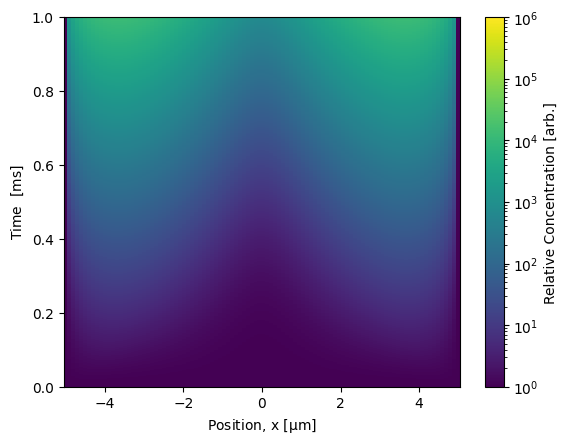

In [16]:
plt.pcolor(X_g*1e6,T_g*1e3,(c_plus2+c_minus2)/2,norm=mpl.colors.LogNorm())
plt.colorbar(label = 'Relative Concentration [arb.]')
plt.clim([1,1e6])
plt.xlabel('Position, x $\\mathrm{[\\mu m]}$')
plt.ylabel('Time $~\\mathrm{[ms]}$');

### Fit concentration time dynamics near electrodes to a logY function
$\log_{10}(y) = mx+\log_{10}(b)$

In [17]:
def logyFit(x,a,b):
    return a*10**(b*x)

In [18]:
popt,pcov = scipy.optimize.curve_fit(logyFit,t,(c_plus2+c_minus2)[:,10]/2,p0=[1,5000])
popt, pcov

(array([7.92695452e-01, 4.16633711e+03]),
 array([[ 1.64155281e-10, -9.45455343e-08],
        [-9.45455343e-08,  5.46181289e-05]]))

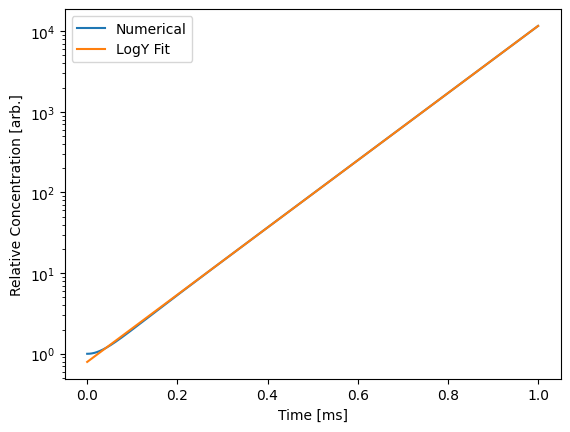

In [19]:
plt.semilogy(t*1e3,(c_plus2+c_minus2)[:,10]/2,label='Numerical')
plt.plot(t*1e3,logyFit(t,*popt),label='LogY Fit')
plt.xlabel('Time [ms]')
plt.ylabel('Relative Concentration [arb.]')
plt.legend();

### Low electric field attenuation in the active-area requires $~<100 \mu s$ on time

### Try now with a sinusoidal applied voltage of 10 kHz

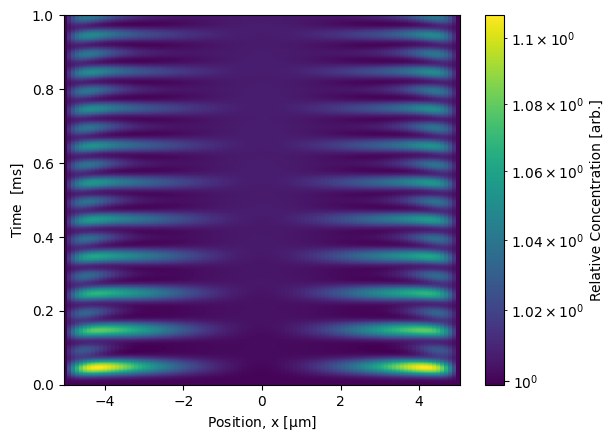

In [20]:
c0 = np.ones((nx))

z = 2
c = []
c.append(c0)

n = 1
i = 0
for t_temp in t:
    if t_temp > 0:
        i = 0
        dt = t[n]-t[n-1]
        c_temp = np.zeros(nx)
        for x_temp in x:
            if (i-1 < 0) or (i+1 >= nx):
                c_temp[i] = c0[i] # Dirchlet BC
            else:
                c_temp[i] = c[n-1][i]+D*dt*((c[n-1][i+1]-2*c[n-1][i]+c[n-1][i-1])/(dy**2)+((z*laplaceVx(x_temp)*np.sin(2*np.pi*1e4*t_temp))/(kB*T))*c[n-1][i])
                if c_temp[i] < 0:
                    c_temp[i] = 0
            i += 1
        c.append(c_temp)
        n += 1           
c_plus2_sin = np.array(c)

z = -2
c = []
c.append(c0)

n = 1
i = 0
for t_temp in t:
    if t_temp > 0:
        i = 0
        dt = t[n]-t[n-1]
        c_temp = np.zeros(nx)
        for x_temp in x:
            if (i-1 < 0) or (i+1 >= nx):
                c_temp[i] = c0[i] # Dirchlet BC
            else:
                c_temp[i] = c[n-1][i]+D*dt*((c[n-1][i+1]-2*c[n-1][i]+c[n-1][i-1])/(dy**2)+((z*laplaceVx(x_temp)*np.sin(2*np.pi*1e4*t_temp))/(kB*T))*c[n-1][i])
                if c_temp[i] < 0:
                    c_temp[i] = 0
            i += 1
        c.append(c_temp)
        n += 1              
c_minus2_sin = np.array(c)

plt.pcolor(X_g*1e6,T_g*1e3,(c_plus2_sin+c_minus2_sin)/2,norm=mpl.colors.LogNorm())
plt.colorbar(label = 'Relative Concentration [arb.]')
plt.xlabel('Position, x $\\mathrm{[\\mu m]}$')
plt.ylabel('Time $~\\mathrm{[ms]}$');

### And now voltage pulses with a 10 kHz rep rate

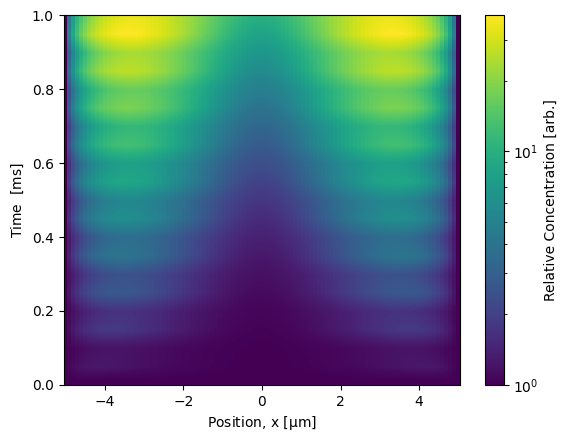

In [21]:
c0 = np.ones((nx))

z = 2
c = []
c.append(c0)

n = 1
i = 0
for t_temp in t:
    if t_temp > 0:
        i = 0
        dt = t[n]-t[n-1]
        c_temp = np.zeros(nx)
        for x_temp in x:
            if (i-1 < 0) or (i+1 >= nx):
                c_temp[i] = c0[i] # Dirchlet BC
            else:
                c_temp[i] = c[n-1][i]+D*dt*((c[n-1][i+1]-2*c[n-1][i]+c[n-1][i-1])/(dy**2)+((z*laplaceVx(x_temp)*(scipy.signal.square(2*np.pi*1e4*t_temp)+1)/2)/(kB*T))*c[n-1][i])
                if c_temp[i] < 0:
                    c_temp[i] = 0
            i += 1
        c.append(c_temp)
        n += 1           
c_plus2_sq = np.array(c)

z = -2
c = []
c.append(c0)

n = 1
i = 0
for t_temp in t:
    if t_temp > 0:
        i = 0
        dt = t[n]-t[n-1]
        c_temp = np.zeros(nx)
        for x_temp in x:
            if (i-1 < 0) or (i+1 >= nx):
                c_temp[i] = c0[i] # Dirchlet BC
            else:
                c_temp[i] = c[n-1][i]+D*dt*((c[n-1][i+1]-2*c[n-1][i]+c[n-1][i-1])/(dy**2)+((z*laplaceVx(x_temp)*(scipy.signal.square(2*np.pi*1e4*t_temp)+1)/2)/(kB*T))*c[n-1][i])
                if c_temp[i] < 0:
                    c_temp[i] = 0
            i += 1
        c.append(c_temp)
        n += 1              
c_minus2_sq = np.array(c)

plt.pcolor(X_g*1e6,T_g*1e3,(c_plus2_sq+c_minus2_sq)/2,norm=mpl.colors.LogNorm())
plt.colorbar(label = 'Relative Concentration [arb.]')
plt.xlabel('Position, x $\\mathrm{[\\mu m]}$')
plt.ylabel('Time $~\\mathrm{[ms]}$');

# DNA Hairpin Model (Entropic Spring with Charged/Bonding Ends)

In [6]:
l_bp = 0.5e-9 # average DNA bp length
q_bp = -6*e # -6e charge from 2 -3e phosphate groups on DNA backbone
n_bp = 40 # number of base pairs

r_test = np.linspace(0,n_bp*l_bp,1001)

f = lambda r: ((kB*T)/l_bp)*((3*r)/(n_bp*l_bp)+(1/5)*(r/(n_bp*l_bp))**2*np.sin((7*r)/(2*n_bp*l_bp))+(r/(n_bp*l_bp))**3/(1-r/(n_bp*l_bp)))
F = scipy.integrate.cumulative_trapezoid(f(r_test),r_test)
F = np.insert(F,0,0)

Ue = lambda r: ((q_bp)**2/(4*np.pi*eps0*r*e))

eps = 10
sigma = 3e-9*2**(1/6)
U_LJ = lambda r: 4*eps*((sigma/r)**12-(sigma/r)**6)

G_tot = F+Ue(r_test)+U_LJ(r_test)

E_app = 1e5
U_E = lambda r: -(q_bp*7*E_app*r)/e

C:\Users\gbim9\AppData\Local\Temp\ipykernel_21056\29542218.py:7: RuntimeWarning: divide by zero encountered in divide
  f = lambda r: ((kB*T)/l_bp)*((3*r)/(n_bp*l_bp)+(1/5)*(r/(n_bp*l_bp))**2*np.sin((7*r)/(2*n_bp*l_bp))+(r/(n_bp*l_bp))**3/(1-r/(n_bp*l_bp)))
C:\Users\gbim9\AppData\Local\Temp\ipykernel_21056\29542218.py:11: RuntimeWarning: divide by zero encountered in divide
  Ue = lambda r: ((q_bp)**2/(4*np.pi*eps0*r*e))
C:\Users\gbim9\AppData\Local\Temp\ipykernel_21056\29542218.py:15: RuntimeWarning: divide by zero encountered in divide
  U_LJ = lambda r: 4*eps*((sigma/r)**12-(sigma/r)**6)
C:\Users\gbim9\AppData\Local\Temp\ipykernel_21056\29542218.py:15: RuntimeWarning: invalid value encountered in subtract
  U_LJ = lambda r: 4*eps*((sigma/r)**12-(sigma/r)**6)


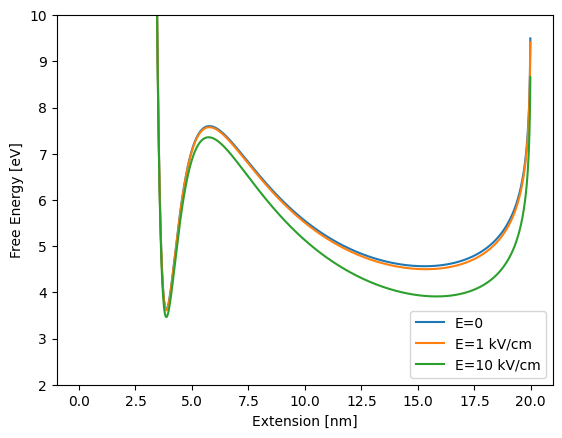

In [7]:
plt.plot(r_test*1e9,G_tot,label='E=0')
plt.plot(r_test*1e9,G_tot-U_E(r_test),label='E=1 kV/cm')
plt.plot(r_test*1e9,G_tot-10*U_E(r_test),label='E=10 kV/cm')
# plt.ylim([4,6])
plt.ylim([2,10])
plt.xlabel('Extension [nm]')
plt.ylabel('Free Energy [eV]')
plt.legend()

### Calculate rate constants using transition state theory
$k_{f} = \frac{k_{B}T}{h}e^{-\frac{\Delta G^{\ddagger}}{k_{B}T}}\\$
$K_{eq} = k_{f}/k_{r} = \frac{k_{B}T}{h}e^{-\frac{\Delta G}{k_{B}T}}$

In [8]:
def GetKs(G):
    idx_mins = scipy.signal.argrelextrema(G,np.less)[0]
    if len(idx_mins)>1:
        idx_min0 = int(idx_mins[0])
        idx_min1 = int(idx_mins[1])
        idx_max = int(scipy.signal.argrelextrema(G,np.greater)[0][0])
        kf = (kB*T*np.exp(-(G[idx_max]-G[idx_min0])/(kB*T)))/h
        Keq = (kB*T*np.exp(-(G[idx_min1]-G[idx_min0])/(kB*T)))/h
        kr = kf/Keq
    else:
        kf = 0
        kr = 0
        Keq = 0
    return kf,kr,Keq

In [13]:
print('K_eq = '+str(GetKs(G_tot)[2]))
print('K_eq(E) = '+str(GetKs(G_tot-U_E(r_test))[2]))
print('DeltaK_eq(E) = '+str(GetKs(G_tot-U_E(r_test))[2]/GetKs(G_tot)[2]))

K_eq = 0.0011082199735631272
K_eq(E) = 0.007137551530042569
DeltaK_eq(E) = 6.440554854009762


### Now add in time dependent electric field (due to shielding and pulsing) $\rightarrow$ non-equilibrium chemical kinetics
$\frac{d[P]}{dt} = k_{f}(t)[R]-k_{r}(t)[P]$

6.774549620985588e-07 1.1082199735631272e-06


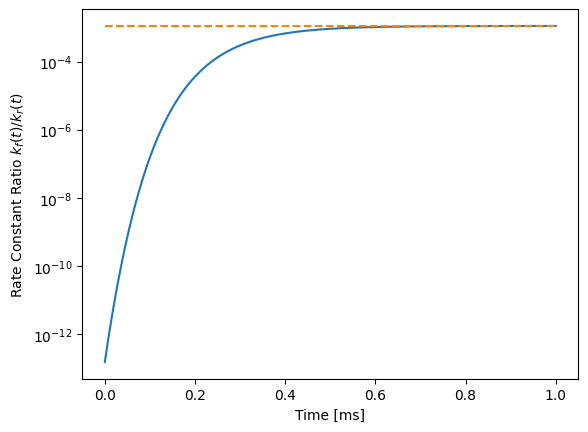

In [26]:
K0 = GetKs(G_tot)[2]

t_test = np.linspace(0,1e-3,1001)

K_test = []
for i in range(len(t_test)):
    K_test.append(GetKs(G_tot+(U_E(r_test)*10)/logyFit(t_test[i],*popt))[2])

plt.semilogy(t_test*1e3,K_test)
plt.semilogy([t_test[0]*1e3,t_test[-1]*1e3],[K0,K0],'--')
plt.xlabel('Time [ms]')
plt.ylabel('Rate Constant Ratio $k_{f}(t)/k_{r}(t)$')
print(scipy.integrate.trapezoid(K_test,t_test),K0*(t_test[-1]-t_test[0]))

### Playing around with shifting peaks using a superimposed line

In [27]:
a = 1
b = 0
c = 1
GP = lambda x: a*np.exp(-(x-b)**2/(2*c**2))

m = 1/5
d = 0
Pert = lambda x: m*x+d

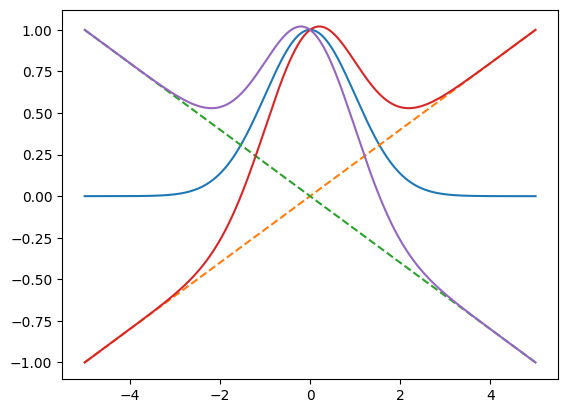

In [28]:
x_test = np.linspace(-5,5,1001)
plt.plot(x_test,GP(x_test))
plt.plot(x_test,Pert(x_test),'--')
plt.plot(x_test,-Pert(x_test),'--')
plt.plot(x_test,GP(x_test)+Pert(x_test))
plt.plot(x_test,GP(x_test)-Pert(x_test))